In [ ]:
!pip install pmdarima
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

import pandas_datareader.data as web
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from talib import abstract
import json

(Reading database ... 161006 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [ ]:
def mean_absolute_percentage_error(actual, prediction):
    actual = pd.Series(actual)
    prediction = pd.Series(prediction)
    return 100 * np.mean(np.abs((actual - prediction))/actual)

def get_arima(data, train_len, test_len):
    # prepare train and test data
    data = data.tail(test_len + train_len).reset_index(drop=True)
    train = data.head(train_len).values.tolist()
    test = data.tail(test_len).values.tolist()

    # Initialize model
    model = auto_arima(train, max_p=3, max_q=3, seasonal=False, trace=True,
                       error_action='ignore', suppress_warnings=True)

    # Determine model parameters
    model.fit(train)
    order = model.get_params()['order']
    print('ARIMA order:', order, '\n')

    # Genereate predictions
    prediction = []
    for i in range(len(test)):
        model = pm.ARIMA(order=order)
        model.fit(train)
        print('working on', i+1, 'of', test_len, '-- ' + str(int(100 * (i + 1) / test_len)) + '% complete')
        prediction.append(model.predict()[0])
        train.append(test[i])

    # Generate error data
    mse = mean_squared_error(test, prediction)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(pd.Series(test), pd.Series(prediction))
    return prediction, mse, rmse, mape

def get_lstm(data, train_len, test_len, lstm_len=4):
    # prepare train and test data
    data = data.tail(test_len + train_len).reset_index(drop=True)
    dataset = np.reshape(data.values, (len(data), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)
    x_train = []
    y_train = []
    x_test = []

    for i in range(lstm_len, train_len):
        x_train.append(dataset_scaled[i - lstm_len:i, 0])
        y_train.append(dataset_scaled[i, 0])
    for i in range(train_len, len(dataset_scaled)):
        x_test.append(dataset_scaled[i - lstm_len:i, 0])

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Set up & fit LSTM RNN
    model = Sequential()
    model.add(LSTM(units=lstm_len, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=int(lstm_len/2)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
    model.fit(x_train, y_train, epochs=200, batch_size=1, verbose=2, callbacks=[early_stopping])

    # Generate predictions
    prediction = model.predict(x_test)
    prediction = scaler.inverse_transform(prediction).tolist()

    output = []
    for i in range(len(prediction)):
        output.extend(prediction[i])
    prediction = output

    # Generate error data
    mse = mean_squared_error(data.tail(len(prediction)).values, prediction)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(data.tail(len(prediction)).reset_index(drop=True), pd.Series(prediction))
    return prediction, mse, rmse, mape

def retrieve_data(stock_name):
    import datetime
    #over 20 years worth of data (from start of century)
    start = datetime.datetime(2011, 1, 1)
    end = datetime.datetime(2021, 1, 1)

    #access yahoo finance database
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Adj Close'], 1, inplace=True)

    #create a percent change of closing values column
    df['Pct Change'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

In [ ]:
stock_name = input("Stock Ticker: ")
data = retrieve_data(stock_name)
neworder = ['Open','High','Low','Close', 'Volume', 'Pct Change']
data = data.reindex(columns=neworder)

data.columns = ['open', 'high', 'low', 'close', 'volume', 'pct change']
print(data.keys())

talib_moving_averages = ['SMA']
#, 'EMA', 'WMA', 'DEMA', 'MIDPOINT', 'MIDPRICE'
functions = {}
for ma in talib_moving_averages:
  functions[ma] = abstract.Function(ma)

print(functions)

kurtosis_results = {'period': []}
for i in range(4, 100):
    kurtosis_results['period'].append(i)
    for ma in talib_moving_averages:
        # Run moving average, remove last 252 days (used later for test data set), trim MA result to last 60 days
        ma_output = functions[ma](data[:-100], i).tail(60)

        # Determine kurtosis "K" value
        k = kurtosis(ma_output, fisher=False)

        # add to dictionary
        if ma not in kurtosis_results.keys():
            kurtosis_results[ma] = []
        kurtosis_results[ma].append(k)

kurtosis_results = pd.DataFrame(kurtosis_results)
kurtosis_results.to_csv('kurtosis_results.csv')

# Determine period with K closest to 3 +/-5%
optimized_period = {}
for ma in talib_moving_averages:
    difference = np.abs(kurtosis_results[ma] - 3)
    df = pd.DataFrame({'difference': difference, 'period': kurtosis_results['period']})
    df = df.sort_values(by=['difference'], ascending=True).reset_index(drop=True)
    if df.at[0, 'difference'] < 3 * 0.05:
      optimized_period[ma] = df.at[0, 'period']
    else:
        print(ma + ' is not viable, best K greater or less than 3 +/-5%')

print('\nOptimized periods:', optimized_period)
print(data)

Stock Ticker: GOOG
Index(['open', 'high', 'low', 'close', 'volume', 'pct change'], dtype='object')
{'SMA': {'name': 'SMA', 'group': 'Overlap Studies', 'display_name': 'Simple Moving Average', 'function_flags': ['Output scale same as input'], 'input_names': OrderedDict([('price', 'close')]), 'parameters': OrderedDict([('timeperiod', 30)]), 'output_flags': OrderedDict([('real', ['Line'])]), 'output_names': ['real']}}

Optimized periods: {'SMA': 85}
                   open         high  ...     volume  pct change
Date                                  ...                       
2011-01-04   301.679230   301.958191  ...  3662677.0   -0.003690
2011-01-05   298.914581   304.025452  ...  5083583.0    0.011543
2011-01-06   304.199799   308.060303  ...  4131026.0    0.007273
2011-01-07   306.805023   307.970642  ...  4218152.0    0.004792
2011-01-10   306.252106   306.545990  ...  3170238.0   -0.003618
...                 ...          ...  ...        ...         ...
2020-12-24  1735.000000  1746

In [ ]:
simulation = {}
for ma in optimized_period:
    # Split data into low volatility and high volatility time series
    low_vol = functions[ma](data, int(optimized_period[ma]))
    high_vol = data['close'] - low_vol
    print(low_vol)

    # Generate ARIMA and LSTM predictions
    print('\nWorking on ' + ma + ' predictions')
    try:
        low_vol_prediction, low_vol_mse, low_vol_rmse, low_vol_mape = get_arima(low_vol, 1000, 252)
    except:
        print('ARIMA error, skipping to next MA type')
        continue

    high_vol_prediction, high_vol_mse, high_vol_rmse, high_vol_mape = get_lstm(high_vol, 1000, 252)

    final_prediction = pd.Series(low_vol_prediction) + pd.Series(high_vol_prediction)
    mse = mean_squared_error(final_prediction.values, data['close'].tail(252).values)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(data['close'].tail(252).reset_index(drop=True), final_prediction)

    # Generate prediction accuracy
    actual = data['close'].tail(252).values
    result_1 = []
    result_2 = []
    for i in range(1, len(final_prediction)):
        # Compare prediction to previous close price
        if final_prediction[i] > actual[i-1] and actual[i] > actual[i-1]:
            result_1.append(1)
        elif final_prediction[i] < actual[i-1] and actual[i] < actual[i-1]:
            result_1.append(1)
        else:
            result_1.append(0)

        # Compare prediction to previous prediction
        if final_prediction[i] > final_prediction[i-1] and actual[i] > actual[i-1]:
            result_2.append(1)
        elif final_prediction[i] < final_prediction[i-1] and actual[i] < actual[i-1]:
            result_2.append(1)
        else:
            result_2.append(0)

    print(result_1)
    print(result_2)

    accuracy_1 = np.mean(result_1)
    accuracy_2 = np.mean(result_2)

    simulation[ma] = {'low_vol': {'prediction': low_vol_prediction, 'mse': low_vol_mse,
                                      'rmse': low_vol_rmse, 'mape': low_vol_mape},
                          'high_vol': {'prediction': high_vol_prediction, 'mse': high_vol_mse,
                                       'rmse': high_vol_rmse},
                          'final': {'prediction': final_prediction.values.tolist(), 'mse': mse,
                                    'rmse': rmse, 'mape': mape},
                          'accuracy': {'prediction vs close': accuracy_1, 'prediction vs prediction': accuracy_2}}

    # save simulation data here as checkpoint
    with open('simulation_data.json', 'w') as fp:
        json.dump(simulation, fp)

Date
2011-01-04            NaN
2011-01-05            NaN
2011-01-06            NaN
2011-01-07            NaN
2011-01-10            NaN
                 ...     
2020-12-24    1640.188589
2020-12-28    1641.644000
2020-12-29    1643.107412
2020-12-30    1644.226353
2020-12-31    1645.611058
Length: 2516, dtype: float64

Working on SMA predictions
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=59.346, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2918.254, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.038, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1809.618, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3179.979, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=57.687, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1168.147, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=64.844, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=59.260, Time=0.93 sec
 ARIMA(0,1,3)(0,0,0)[0] i


SMA
{'prediction vs close': 0.450199203187251, 'prediction vs prediction': 0.4581673306772908}
Simple Moving Average
Prediction vs Close:		45.02% Accuracy
Prediction vs Prediction:	45.82% Accuracy
MSE:	 1394.1406736761205 
RMSE:	 37.3381932299371 
MAPE:	 2.0276683230489234


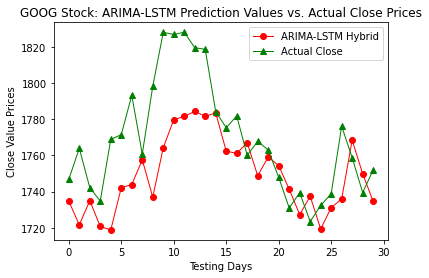

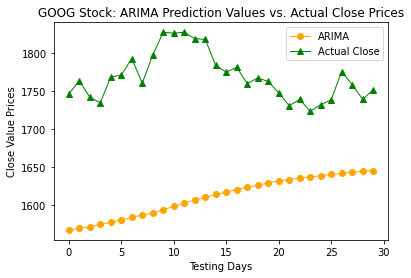

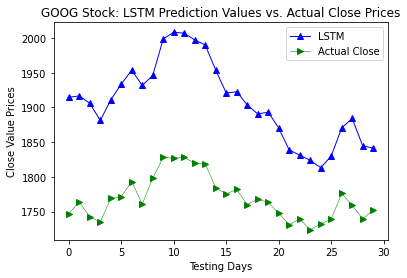

12.002799791632015
42.269499991745306
7.182692965083561
14.104791211415886
50.013046194336994
29.2286490205463
49.31256311037782
3.165681498656568
61.11376500614506
63.72132333228956
47.078217259992925
46.47522660970844
35.1653306889998
36.97378378201984
0.6875164029659118
13.001825866844683
20.61341262502151
6.887540897627559
19.00898165589024
3.8143586638914257
6.4654156989274725
10.278323279513188
12.072842696157068
13.944931073632688
13.021867518917588
7.655654709291639
40.12456830487076
9.698450826583667
10.339861734270698
17.235909763114933
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[]
[]


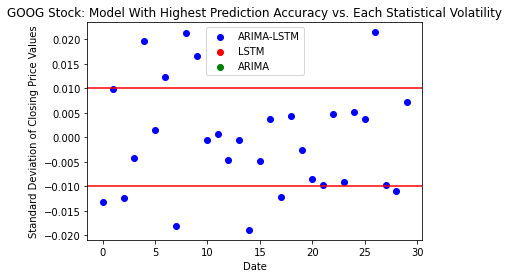

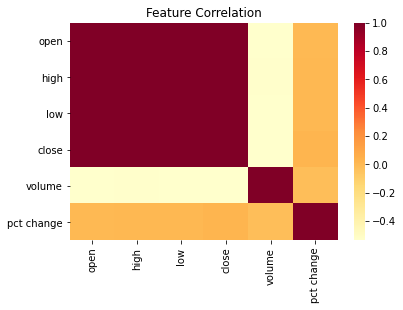


Correlation Between Features
                open      high       low     close    volume  pct change
open        1.000000  0.999818  0.999761  0.999580 -0.532839    0.004982
high        0.999818  1.000000  0.999702  0.999779 -0.530126    0.012897
low         0.999761  0.999702  1.000000  0.999814 -0.536856    0.015332
close       0.999580  0.999779  0.999814  1.000000 -0.534020    0.024470
volume     -0.532839 -0.530126 -0.536856 -0.534020  1.000000   -0.019712
pct change  0.004982  0.012897  0.015332  0.024470 -0.019712    1.000000


In [ ]:
for ma in simulation.keys():
    print('\n' + ma)
    print(simulation[ma]['accuracy'])
    print("Simple Moving Average")
    print('Prediction vs Close:\t\t' + str(round(100*simulation[ma]['accuracy']['prediction vs close'], 2))
          + '% Accuracy')
    print('Prediction vs Prediction:\t' + str(round(100*simulation[ma]['accuracy']['prediction vs prediction'], 2))
           + '% Accuracy')
    print('MSE:\t', simulation[ma]['final']['mse'],
          '\nRMSE:\t', simulation[ma]['final']['rmse'],
          '\nMAPE:\t', simulation[ma]['final']['mape'])
    
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
import matplotlib.pyplot as plt4
import matplotlib.pyplot as plt5
import matplotlib.pyplot as plt6

plt.plot(simulation[ma]['final']['prediction'][222:252], marker = "o", color='red', label='ARIMA-LSTM Hybrid', linewidth = 1)
plt.plot(actual[222:252], color='green', label='Actual Close', marker = "^", linewidth = 1)
plt.legend(loc='best')
plt.ylabel("Close Value Prices")
plt.xlabel("Testing Days")
plt.title(stock_name + " Stock: ARIMA-LSTM Prediction Values vs. Actual Close Prices")
plt.show()

plt4.plot(simulation[ma]['low_vol']['prediction'][222:252], marker = "o", color='orange', label='ARIMA', linewidth = 1)
plt4.plot(actual[222:252], color='green', label='Actual Close', marker = "^", linewidth = 1)
plt4.legend(loc='best')
plt4.ylabel("Close Value Prices")
plt4.xlabel("Testing Days")
plt4.title(stock_name + " Stock: ARIMA Prediction Values vs. Actual Close Prices")
plt4.show()

plt5.plot(simulation[ma]['high_vol']['prediction'][222:252] + actual[222:252], marker = "^", color='blue', label='LSTM', linewidth = 1)
plt5.plot(actual[222:252], color='green', label='Actual Close', marker = ">", linewidth = .5)
plt5.legend(loc='best')
plt5.ylabel("Close Value Prices")
plt5.xlabel("Testing Days")
plt5.title(stock_name + " Stock: LSTM Prediction Values vs. Actual Close Prices")
plt5.show()

import math
arima_lstm_scatter = []
arima_lstm_scatter_y = []

lstm_scatter = []
lstm_scatter_y = []

arima_scatter = []
arima_scatter_y = []

for i in range(0,30):
  value = abs(simulation[ma]['final']['prediction'][222+i] - actual[222+i])
  print(value)
  if (value > abs(simulation[ma]['low_vol']['prediction'][222+i] - actual[222+i])) and value <= abs(simulation[ma]['high_vol']['prediction'][222+i] - actual[222+i]):
    arima_scatter.append(i)
  elif value > abs(simulation[ma]['high_vol']['prediction'][222+i] - actual[222+i]) and value <= abs(simulation[ma]['low_vol']['prediction'][222+i] - actual[222+i]):
    lstm_scatter.append(i)
  else:
    arima_lstm_scatter.append(i)
print(arima_lstm_scatter)
print(arima_scatter)
print(lstm_scatter)
for i in arima_lstm_scatter:
  arima_lstm_scatter_y.append(data['pct change'][-30+i])
for i in lstm_scatter:
  lstm_scatter_y.append(data['pct change'][-30+i])
for i in arima_scatter:
  arima_scatter_y.append(data['pct change'][-30+i])
plt3.scatter(arima_lstm_scatter, arima_lstm_scatter_y, marker = "o", color = "blue", label = "ARIMA-LSTM")
plt3.scatter(lstm_scatter, lstm_scatter_y, marker = "o", color = "red", label = "LSTM")
plt3.scatter(arima_scatter, arima_scatter_y, marker = "o", color = "green", label = "ARIMA")
plt.axhline(y=-0.01, color='r', linestyle='-')
plt.axhline(y=0.01, color='r', linestyle='-')
plt3.legend(loc='best')
plt3.ylabel("Standard Deviation of Closing Price Values")
plt3.xlabel("Date")
plt3.title(stock_name + " Stock: Model With Highest Prediction Accuracy vs. Each Statistical Volatility")
plt3.show()

#print("ARIMA-LSTM: Overall - %" + (arima_lstm_scatter.count / 30 * 100) + " No volatility - %" + (12 #/ 15 * 100) + " Fall Volaltility - %" + (2 / 6 * 100) + " Rise Volaitlity - %" + (5 / 9 * 100))
#print("ARIMA-LSTM: Overall - %" + (lstm_scatter.count / 30 * 100) + " No volatility - %" + (3 / 15 * 100) + " Fall Volaltility - %" + (4 / 6 * 100) + " Rise Volaitlity - %" + (4 / 9 * 100))

import seaborn as sns
corr = data.corr()
ax = sns.heatmap(corr, cmap="YlOrRd")
ax.set_title("Feature Correlation")
plt.show()
print("\nCorrelation Between Features")
print(corr)

Stock Ticker: GOOG
                   Open         High  ...      Volume  Pct Change
Date                                  ...                        
2004-08-20    50.316402    54.336334  ...  22942874.0    0.079430
2004-08-23    55.168217    56.528118  ...  18342897.0    0.010064
2004-08-24    55.412300    55.591629  ...  15319808.0   -0.041408
2004-08-25    52.284027    53.798351  ...   9232276.0    0.010775
2004-08-26    52.279045    53.773445  ...   7128620.0    0.018019
...                 ...          ...  ...         ...         ...
2020-12-24  1735.000000  1746.000000  ...    346800.0    0.003735
2020-12-28  1751.635010  1790.728027  ...   1393000.0    0.021416
2020-12-29  1787.790039  1792.439941  ...   1299400.0   -0.009780
2020-12-30  1762.010010  1765.094971  ...   1306100.0   -0.010917
2020-12-31  1735.420044  1758.930054  ...   1011900.0    0.007105

[4121 rows x 6 columns]


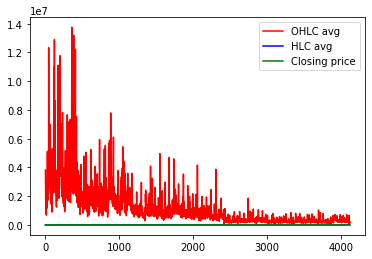

Epoch 1/5
3088/3088 - 10s - loss: 0.0125
Epoch 2/5
3088/3088 - 8s - loss: 0.0106
Epoch 3/5
3088/3088 - 7s - loss: 0.0105
Epoch 4/5
3088/3088 - 8s - loss: 0.0104
Epoch 5/5
3088/3088 - 8s - loss: 0.0104
Train RMSE: 1401766.22
Test RMSE: 1129835.81


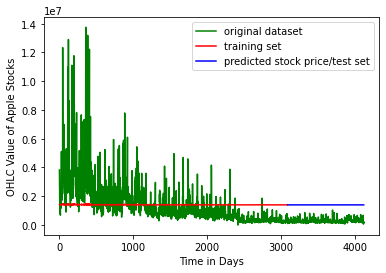

In [ ]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
stock_name = input("Stock Ticker: ")
data = retrieve_data(stock_name)
neworder = ['Open','High','Low','Close', 'Volume', 'Pct Change']
data = data.reindex(columns=neworder)

train = 